In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns


In [3]:
vald_data = pd.read_csv('data/model_data.csv')

In [4]:
# Display basic information and first few rows for review
vald_data_info = vald_data.info()
vald_data_head = vald_data.head()

vald_data_info, vald_data_head

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 972 entries, 0 to 971
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   sbuid             972 non-null    float64
 1   testDateUtc       972 non-null    object 
 2   leftAvgForce      972 non-null    float64
 3   leftImpulse       972 non-null    float64
 4   leftMaxForce      972 non-null    float64
 5   leftTorque        972 non-null    float64
 6   rightAvgForce     972 non-null    float64
 7   rightImpulse      972 non-null    float64
 8   rightMaxForce     972 non-null    float64
 9   rightTorque       972 non-null    float64
 10  ForceSymmetry     972 non-null    float64
 11  ImpulseSymmetry   972 non-null    float64
 12  MaxForceSymmetry  972 non-null    float64
 13  TorqueSymmetry    972 non-null    float64
dtypes: float64(13), object(1)
memory usage: 106.4+ KB


(None,
         sbuid testDateUtc  leftAvgForce  leftImpulse  leftMaxForce  \
 0  14568521.0  2022-01-28    364.812500     6375.605        450.75   
 1  14568521.0  2022-03-24    460.750000     8661.625        473.00   
 2  14568521.0  2022-05-27    465.750000     8750.730        481.25   
 3  14568521.0  2022-06-17    448.000000     9147.955        462.50   
 4  14568521.0  2022-07-01    496.583333     9311.730        508.25   
 
    leftTorque  rightAvgForce  rightImpulse  rightMaxForce  rightTorque  \
 0  184.582125     347.937500      6104.060         451.50   184.889250   
 1  193.693500     511.833333      8758.945         529.25   216.727875   
 2  197.071875     491.583333      8295.600         521.00   213.349500   
 3  189.393750     418.916667      8099.180         443.25   181.510875   
 4  208.128375     478.000000      7821.835         504.00   206.388000   
 
    ForceSymmetry  ImpulseSymmetry  MaxForceSymmetry  TorqueSymmetry  
 0       1.048500         1.044486        

In [5]:
# Define the provided thresholds for symmetry metrics
symmetry_thresholds = {
    'ForceSymmetry': (250 / 310, 300 / 260),  # Based on AvgForce thresholds
    'ImpulseSymmetry': (150 / 260, 250 / 160),  # Based on Impulse thresholds
    'MaxForceSymmetry': (270 / 330, 320 / 280),  # Based on MaxForce thresholds
    'TorqueSymmetry': (250 / 310, 300 / 260)  # Based on Torque thresholds
}

In [6]:
def calculate_symmetry_risk(data, thresholds, metric_stds=None, buffer_factor=1.0):
    for metric, (min_val, max_val) in thresholds.items():
        # Use dynamic buffer based on metric standard deviation
        if metric_stds:
            buffer = metric_stds[metric] * buffer_factor
        else:
            buffer = (max_val - min_val) * 0.1  # Default 10% buffer

        data[f'{metric}Risk'] = data[metric].apply(
            lambda x: 'Low Risk' if min_val <= x <= max_val
            else 'Medium Risk' if (min_val - buffer <= x < min_val) or (max_val < x <= max_val + buffer)
            else 'High Risk'
        )
    return data


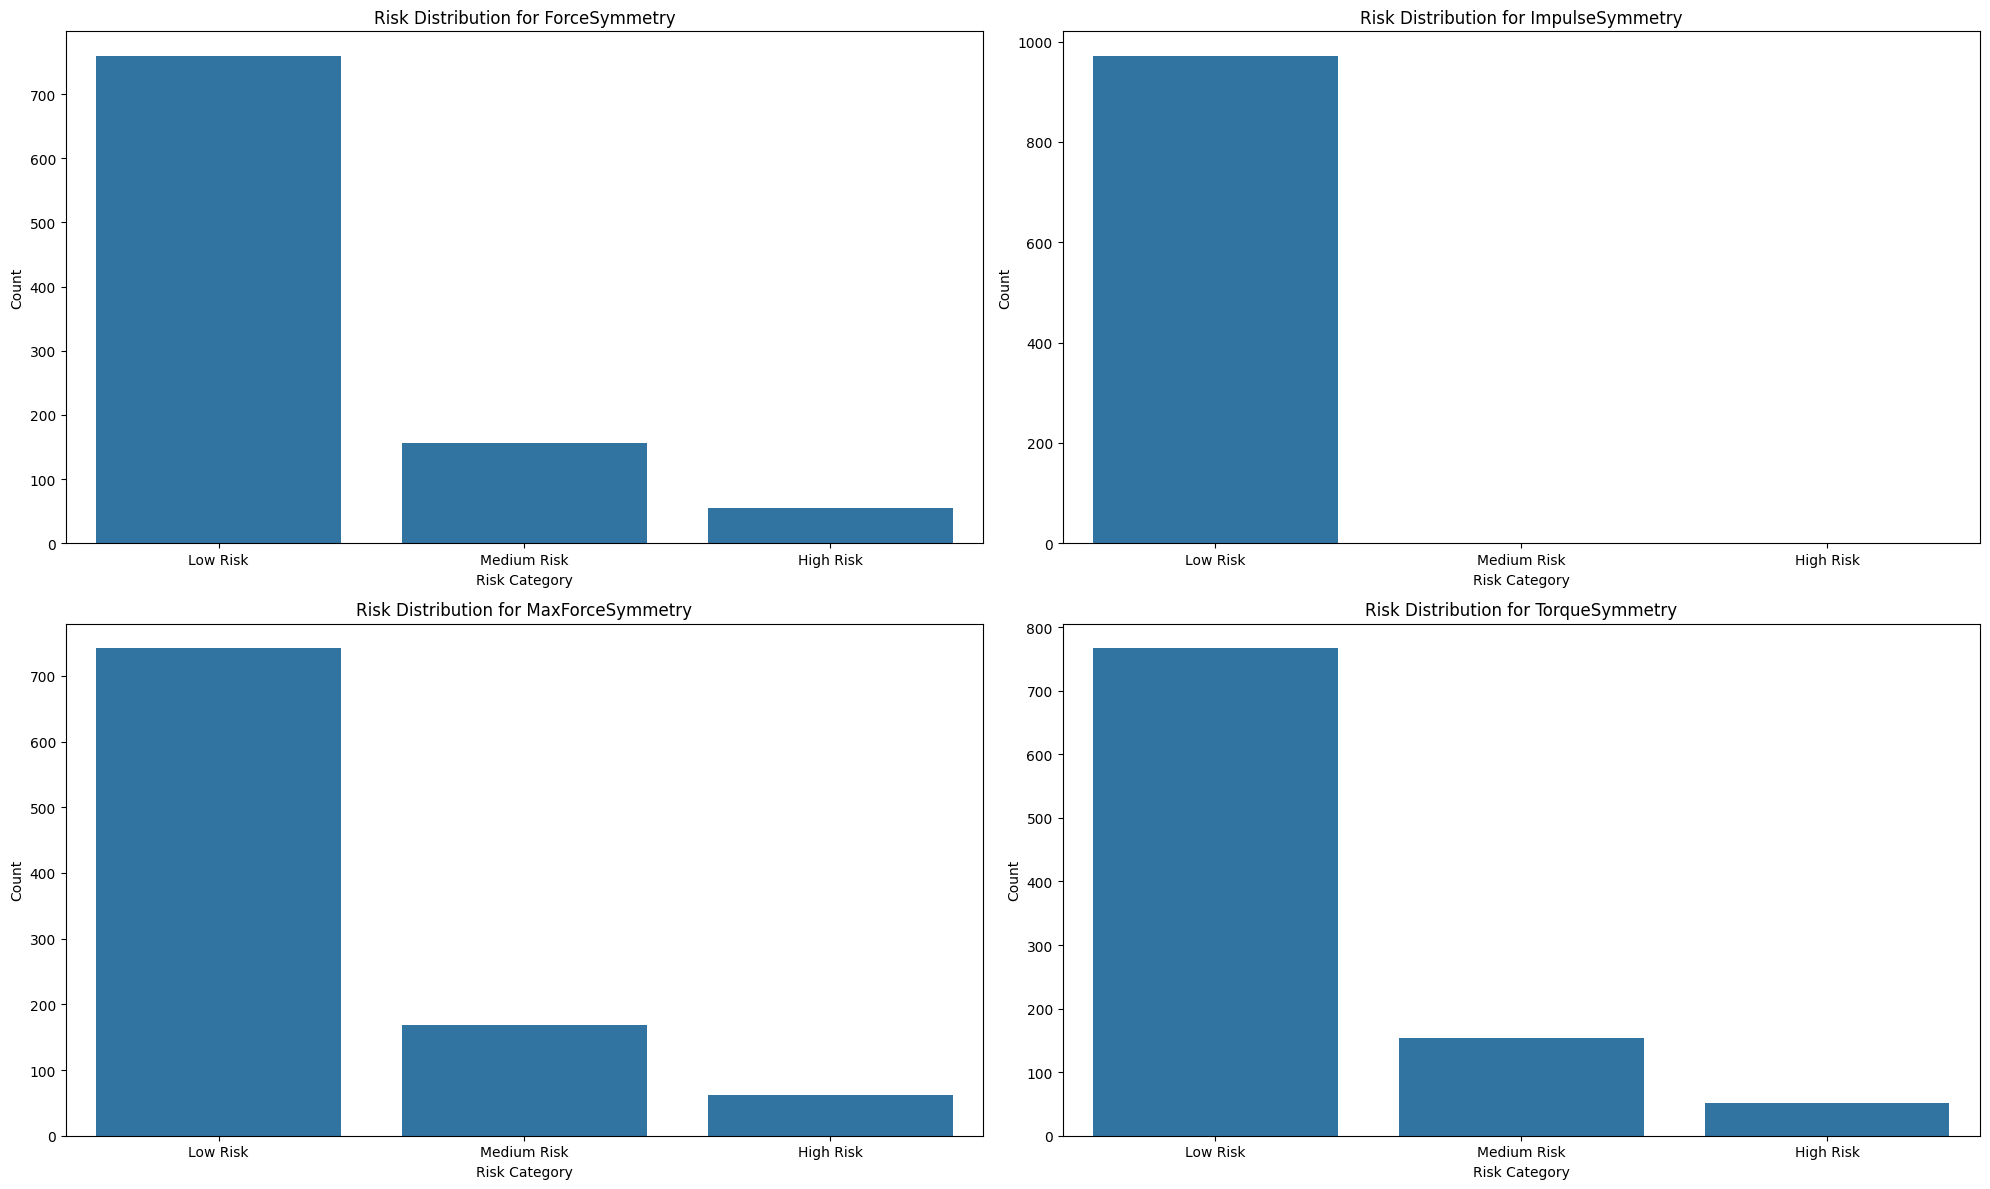

In [7]:

# Calculate standard deviations for symmetry metrics
symmetry_metrics = ['ForceSymmetry', 'ImpulseSymmetry', 'MaxForceSymmetry', 'TorqueSymmetry']
metric_stds = vald_data[symmetry_metrics].std().to_dict()

# Apply the updated logic with dynamic buffers based on standard deviations
def calculate_symmetry_risk_dynamic(data, thresholds, metric_stds=None, buffer_factor=1.0):
    for metric, (min_val, max_val) in thresholds.items():
        # Use dynamic buffer based on metric standard deviation
        buffer = metric_stds[metric] * buffer_factor if metric_stds else (max_val - min_val) * 0.1
        data[f'{metric}Risk'] = data[metric].apply(
            lambda x: 'Low Risk' if min_val <= x <= max_val
            else 'Medium Risk' if (min_val - buffer <= x < min_val) or (max_val < x <= max_val + buffer)
            else 'High Risk'
        )
    return data

# Reapply the logic
vald_data = calculate_symmetry_risk_dynamic(vald_data, symmetry_thresholds, metric_stds, buffer_factor=1.0)

# Visualize risk distribution for each symmetry metric
plt.figure(figsize=(20, 12))
for i, metric in enumerate(symmetry_metrics):
    plt.subplot(2, 2, i + 1)
    sns.countplot(data=vald_data, x=f'{metric}Risk', order=['Low Risk', 'Medium Risk', 'High Risk'])
    plt.title(f'Risk Distribution for {metric}')
    plt.xlabel('Risk Category')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


Step 1: Validate Distribution
What It Does:

Analyzes the proportions of athletes in each risk category (Low Risk, Medium Risk, High Risk) for each symmetry metric.
How It Helps:

Ensures that the thresholds and buffer logic produce meaningful distributions.
Identifies potential issues, such as:
Overrepresentation of a specific category (e.g., too many in Low Risk).
Underrepresentation of Medium Risk or High Risk, which could indicate overly strict thresholds or inappropriate buffer sizes.
Allows refinement of thresholds and buffers to align with domain expectations.
Outcome:

A clear understanding of the distribution of athletes across risk levels for each metric.
Validation or refinement of the risk categorization logic.

Step 2: Statistical Validation (Hypothesis Testing)
What It Does:

Tests whether symmetry metrics differ significantly between risk categories (Low Risk, Medium Risk, High Risk).
How It Helps:

Adds statistical rigor to support your thresholds:
For example, does ForceSymmetry significantly differ across risk levels? If not, the thresholds may not align with meaningful separation.
Validates that the risk categories represent distinct groups based on the symmetry metrics.
Identifies metrics that are most relevant for risk categorization (e.g., metrics with significant differences across groups).
Outcome:

Evidence-backed conclusions about whether the symmetry metrics justify the defined risk categories.
Insights into which metrics are most impactful for risk prediction.

Step 3: Refine Thresholds (if needed)
What It Does:

Adjusts thresholds and buffer logic based on insights from distribution analysis and hypothesis testing.
How It Helps:

Ensures thresholds align with the data distribution and statistical significance.
Allows domain knowledge to guide adjustments (e.g., symmetry ratios closer to 1.0 may require stricter thresholds).
Outcome:

Improved thresholds that create meaningful and balanced risk distributions.
Better alignment between risk categories and the underlying data.

In [8]:
# Validate the distribution of athletes across risk categories for each symmetry metric
risk_distributions = {}
for metric in symmetry_metrics:
    risk_distributions[metric] = vald_data[f'{metric}Risk'].value_counts()

# Convert distributions into a DataFrame for better readability
risk_distribution_df = pd.DataFrame(risk_distributions).transpose()

# Display the distribution 

risk_distribution_df


,High Risk,Low Risk,Medium Risk
ForceSymmetry,55.0,760.0,157.0
ImpulseSymmetry,NaN,972.0,NaN
MaxForceSymmetry,62.0,742.0,168.0
TorqueSymmetry,52.0,767.0,153.0


C:\Users\USER\AppData\Local\Temp\ipykernel_7548\2912958002.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\USER\AppData\Local\Temp\ipykernel_7548\2912958002.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\USER\AppData\Local\Temp\ipykernel_7548\2912958002.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\USER\AppData\Local\Temp\ipykernel_7548\2912958002.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set 

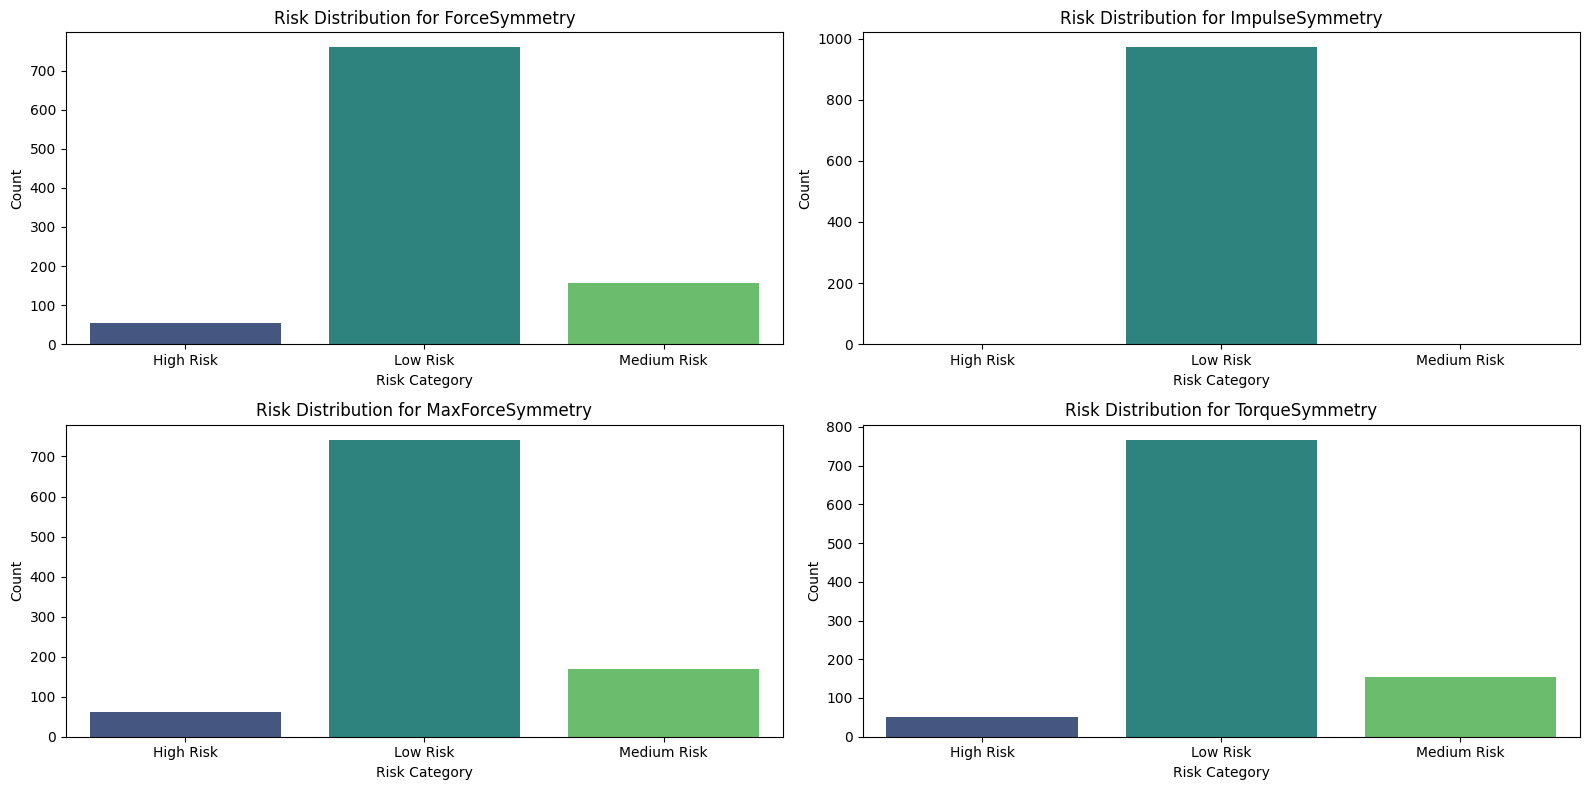

In [9]:
# Visualize the distribution of risk categories for each symmetry metric
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16, 8))
for i, metric in enumerate(symmetry_metrics):
    plt.subplot(2, 2, i + 1)
    sns.barplot(
        x=risk_distribution_df.columns,
        y=risk_distribution_df.loc[metric],
        palette="viridis"
    )
    plt.title(f'Risk Distribution for {metric}')
    plt.xlabel('Risk Category')
    plt.ylabel('Count')

plt.tight_layout()
plt.show()


In [15]:
vald_data.to_csv('data/vald_data_afterrisk.csv', index=False)

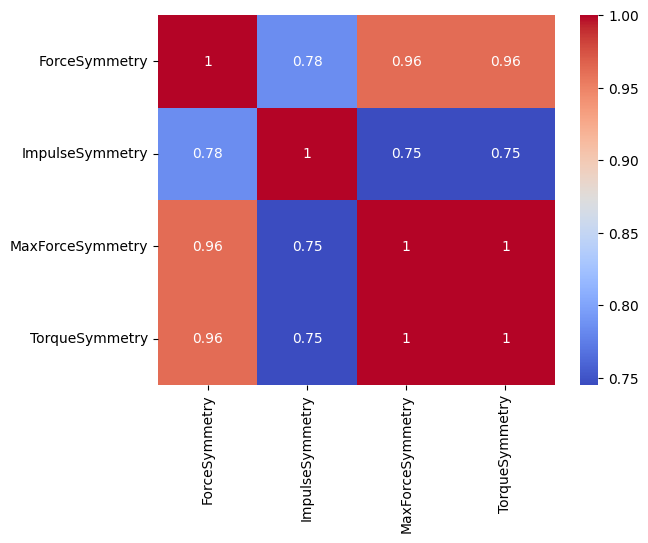

In [10]:
# correlation between symmetry metrics and risk categories
vald_data_corr = vald_data[symmetry_metrics].corr()
sns.heatmap(vald_data_corr, annot=True, cmap='coolwarm')
plt.show()

In [11]:
# Calculate descriptive statistics for Medium and High Risk athletes for each symmetry metric
medium_high_risk_stats = {}

for metric in ['ForceSymmetry', 'MaxForceSymmetry', 'TorqueSymmetry']:
    medium_risk = vald_data[vald_data[f'{metric}Risk'] == 'Medium Risk'][metric]
    high_risk = vald_data[vald_data[f'{metric}Risk'] == 'High Risk'][metric]
    
    medium_high_risk_stats[metric] = {
        'Medium Risk Mean': medium_risk.mean(),
        'Medium Risk Std Dev': medium_risk.std(),
        'High Risk Mean': high_risk.mean(),
        'High Risk Std Dev': high_risk.std(),
        'Medium Risk Count': len(medium_risk),
        'High Risk Count': len(high_risk)
    }

# Convert the statistics to a DataFrame for better readability
medium_high_risk_stats_df = pd.DataFrame(medium_high_risk_stats).transpose()

# Display the statistics
medium_high_risk_stats_df


,Medium Risk Mean,Medium Risk Std Dev,High Risk Mean,High Risk Std Dev,Medium Risk Count,High Risk Count
ForceSymmetry,1.124268,0.175499,1.329894,0.027085,157.0,55.0
MaxForceSymmetry,1.118932,0.166734,1.323772,0.035684,168.0,62.0
TorqueSymmetry,1.128502,0.175017,1.333605,0.030173,153.0,52.0


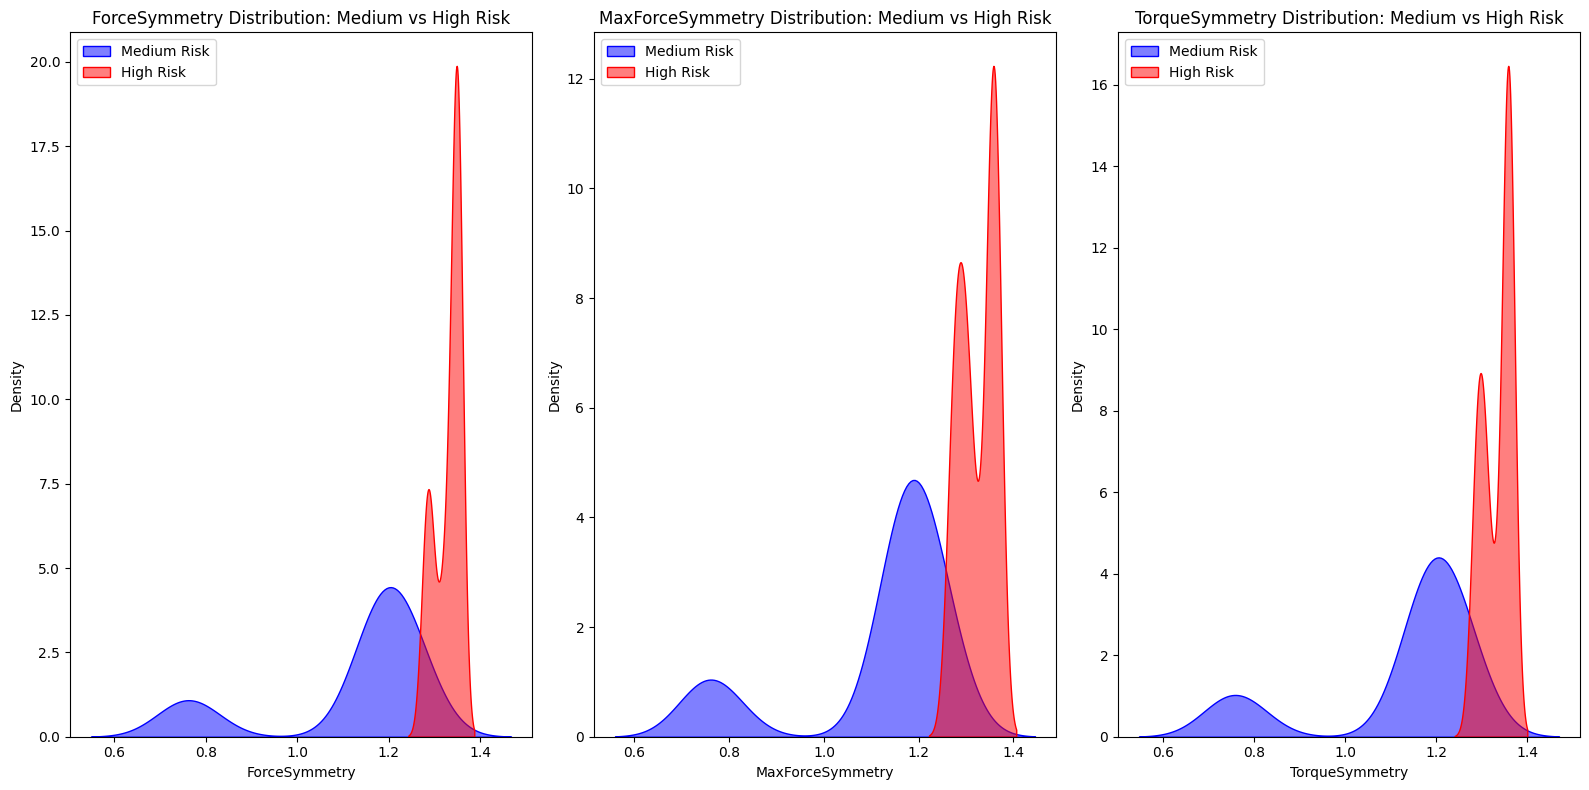

In [12]:
# Visualize the separation between Medium Risk and High Risk for each symmetry metric
plt.figure(figsize=(16, 8))
for i, metric in enumerate(['ForceSymmetry', 'MaxForceSymmetry', 'TorqueSymmetry']):
    plt.subplot(1, 3, i + 1)
    sns.kdeplot(vald_data[vald_data[f'{metric}Risk'] == 'Medium Risk'][metric], label='Medium Risk', color='blue', fill=True, alpha=0.5)
    sns.kdeplot(vald_data[vald_data[f'{metric}Risk'] == 'High Risk'][metric], label='High Risk', color='red', fill=True, alpha=0.5)
    plt.title(f'{metric} Distribution: Medium vs High Risk')
    plt.xlabel(metric)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()


In [13]:
# Create RiskCategory based on the Highest Risk Approach
def assign_highest_risk(row):
    risks = [row['ForceSymmetryRisk'], row['MaxForceSymmetryRisk'], row['TorqueSymmetryRisk']]
    if 'High Risk' in risks:
        return 'High Risk'
    elif 'Medium Risk' in risks:
        return 'Medium Risk'
    else:
        return 'Low Risk'

vald_data['RiskCategory'] = vald_data.apply(assign_highest_risk, axis=1)

# Check the distribution of the newly created RiskCategory
risk_category_distribution = vald_data['RiskCategory'].value_counts()

# Display the distribution
risk_category_distribution


RiskCategory
Low Risk       722
Medium Risk    183
High Risk       67
Name: count, dtype: int64

In [14]:
vald_data

,sbuid,testDateUtc,leftAvgForce,leftImpulse,leftMaxForce,leftTorque,rightAvgForce,rightImpulse,rightMaxForce,rightTorque,ForceSymmetry,ImpulseSymmetry,MaxForceSymmetry,TorqueSymmetry,ForceSymmetryRisk,ImpulseSymmetryRisk,MaxForceSymmetryRisk,TorqueSymmetryRisk,RiskCategory
0,14568521.0,2022-01-28,364.812500,6375.605,450.75,184.582125,347.937500,6104.060,451.50,184.889250,1.048500,1.044486,0.998339,0.998339,Low Risk,Low Risk,Low Risk,Low Risk,Low Risk
1,14568521.0,2022-03-24,460.750000,8661.625,473.00,193.693500,511.833333,8758.945,529.25,216.727875,0.900195,0.988889,0.893718,0.893718,Low Risk,Low Risk,Low Risk,Low Risk,Low Risk
2,14568521.0,2022-05-27,465.750000,8750.730,481.25,197.071875,491.583333,8295.600,521.00,213.349500,0.947449,1.054864,0.923704,0.923704,Low Risk,Low Risk,Low Risk,Low Risk,Low Risk
3,14568521.0,2022-06-17,448.000000,9147.955,462.50,189.393750,418.916667,8099.180,443.25,181.510875,1.069425,1.129492,1.043429,1.043429,Low Risk,Low Risk,Low Risk,Low Risk,Low Risk
4,14568521.0,2022-07-01,496.583333,9311.730,508.25,208.128375,478.000000,7821.835,504.00,206.388000,1.038877,1.190479,1.008433,1.008433,Low Risk,Low Risk,Low Risk,Low Risk,Low Risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,116196314.0,2024-03-19,426.000000,4867.330,426.00,193.617000,515.500000,5686.100,515.50,234.294750,0.826382,0.856005,0.826382,0.826382,Low Risk,Low Risk,Low Risk,Low Risk,Low Risk
968,116196314.0,2024-06-06,414.750000,4018.515,414.75,188.503875,515.750000,4267.670,515.75,234.408375,0.804169,0.941618,0.804169,0.804169,Medium Risk,Low Risk,Medium Risk,Medium Risk,Medium Risk
969,116196314.0,2024-07-03,396.250000,4591.660,396.25,183.661875,512.750000,5257.880,512.75,237.659625,0.772794,0.873291,0.772794,0.772794,Medium Risk,Low Risk,Medium Risk,Medium Risk,Medium Risk
970,116196314.0,2024-07-12,387.250000,5937.870,387.25,179.490375,509.500000,6422.515,509.50,236.153250,0.760059,0.924540,0.760059,0.760059,Medium Risk,Low Risk,Medium Risk,Medium Risk,Medium Risk


In [15]:
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Prepare results storage
models_results = {}

# Step 1: Prepare the data (X and y from vald_data)
risk_mapping = {'Low Risk': 0, 'Medium Risk': 1, 'High Risk': 2}
X = vald_data[['ForceSymmetry', 'MaxForceSymmetry', 'TorqueSymmetry']]
y = vald_data['RiskCategory'].map(risk_mapping)

# MODEL 1: SMOTE Oversampling
smote = SMOTE(random_state=42)
X_resampled_1, y_resampled_1 = smote.fit_resample(X, y)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_resampled_1, y_resampled_1, test_size=0.2, stratify=y_resampled_1, random_state=42)
rf_model_1 = RandomForestClassifier(random_state=42)
rf_model_1.fit(X_train_1, y_train_1)
y_pred_1 = rf_model_1.predict(X_test_1)
models_results['Model 1 (SMOTE)'] = {
    'accuracy': accuracy_score(y_test_1, y_pred_1),
    'classification_report': classification_report(y_test_1, y_pred_1, target_names=risk_mapping.keys()),
    'confusion_matrix': confusion_matrix(y_test_1, y_pred_1),
}

# MODEL 2: No Balancing
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
rf_model_2 = RandomForestClassifier(random_state=42)
rf_model_2.fit(X_train_2, y_train_2)
y_pred_2 = rf_model_2.predict(X_test_2)
models_results['Model 2 (No Balancing)'] = {
    'accuracy': accuracy_score(y_test_2, y_pred_2),
    'classification_report': classification_report(y_test_2, y_pred_2, target_names=risk_mapping.keys()),
    'confusion_matrix': confusion_matrix(y_test_2, y_pred_2),
}

# MODEL 3: SMOTEENN
smoteenn = SMOTEENN(random_state=42)
X_resampled_3, y_resampled_3 = smoteenn.fit_resample(X, y)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_resampled_3, y_resampled_3, test_size=0.2, stratify=y_resampled_3, random_state=42)
rf_model_3 = RandomForestClassifier(random_state=42)
rf_model_3.fit(X_train_3, y_train_3)
y_pred_3 = rf_model_3.predict(X_test_3)
models_results['Model 3 (SMOTEENN)'] = {
    'accuracy': accuracy_score(y_test_3, y_pred_3),
    'classification_report': classification_report(y_test_3, y_pred_3, target_names=risk_mapping.keys()),
    'confusion_matrix': confusion_matrix(y_test_3, y_pred_3),
}

# MODEL 4: Class Weights
rf_model_4 = RandomForestClassifier(random_state=42, class_weight={0: 1, 1: 2, 2: 3})
rf_model_4.fit(X_train_2, y_train_2)  # Use unbalanced data
y_pred_4 = rf_model_4.predict(X_test_2)
models_results['Model 4 (Class Weights)'] = {
    'accuracy': accuracy_score(y_test_2, y_pred_4),
    'classification_report': classification_report(y_test_2, y_pred_4, target_names=risk_mapping.keys()),
    'confusion_matrix': confusion_matrix(y_test_2, y_pred_4),
}


In [16]:
# Print model comparisons
for model_name, results in models_results.items():
    print(f"\n{model_name}")
    print(f"Accuracy: {results['accuracy']}")
    print("Classification Report:")
    print(results['classification_report'])
    print("Confusion Matrix:")
    print(results['confusion_matrix'])



Model 1 (SMOTE)
Accuracy: 0.9838709677419355
Classification Report:
              precision    recall  f1-score   support

    Low Risk       1.00      0.97      0.99       144
 Medium Risk       0.95      1.00      0.98       145
   High Risk       1.00      0.98      0.99       145

    accuracy                           0.98       434
   macro avg       0.98      0.98      0.98       434
weighted avg       0.98      0.98      0.98       434

Confusion Matrix:
[[140   4   0]
 [  0 145   0]
 [  0   3 142]]

Model 2 (No Balancing)
Accuracy: 0.9897435897435898
Classification Report:
              precision    recall  f1-score   support

    Low Risk       1.00      0.99      1.00       145
 Medium Risk       0.95      1.00      0.97        37
   High Risk       1.00      0.92      0.96        13

    accuracy                           0.99       195
   macro avg       0.98      0.97      0.98       195
weighted avg       0.99      0.99      0.99       195

Confusion Matrix:
[[144   1  

In [17]:
import joblib

# Save each model to a file
joblib.dump(rf_model_1, "rf_model_smote.pkl")
joblib.dump(rf_model_2, "rf_model_no_balancing.pkl")
joblib.dump(rf_model_3, "rf_model_smoteenn.pkl")
joblib.dump(rf_model_4, "rf_model_class_weights.pkl")

print("Models saved successfully!")


Models saved successfully!


TESTING ON UNSEEN DATA

In [56]:
# Load unseen data (replace 'unseen_data.csv' with your file name)
unseen_data = pd.read_csv('data/unseen_data.csv')

# Calculate symmetry metrics
unseen_data['ForceSymmetry'] = unseen_data['leftAvgForce'] / unseen_data['rightAvgForce']
unseen_data['ImpulseSymmetry'] = unseen_data['leftImpulse'] / unseen_data['rightImpulse']
unseen_data['MaxForceSymmetry'] = unseen_data['leftMaxForce'] / unseen_data['rightMaxForce']
unseen_data['TorqueSymmetry'] = unseen_data['leftTorque'] / unseen_data['rightTorque']

# Prepare features
X_unseen = unseen_data[['ForceSymmetry', 'MaxForceSymmetry', 'TorqueSymmetry']]

# Predict with all models
unseen_predictions = {}
for model_name, model in zip(
    ['Model 1 (SMOTE)', 'Model 2 (No Balancing)', 'Model 3 (SMOTEENN)', 'Model 4 (Class Weights)'],
    [rf_model_1, rf_model_2, rf_model_3, rf_model_4]
):
    unseen_predictions[model_name] = model.predict(X_unseen)

# Add predictions to unseen data
for model_name in unseen_predictions:
    unseen_data[model_name] = unseen_predictions[model_name]

# Map predictions back to RiskCategory labels
risk_mapping_inverse = {0: 'Low Risk', 1: 'Medium Risk', 2: 'High Risk'}
for model_name in unseen_predictions:
    unseen_data[model_name] = unseen_data[model_name].map(risk_mapping_inverse)

# Display the unseen data with predictions
print(unseen_data)


          sbuid testDateUtc  leftAvgForce  leftImpulse  leftMaxForce  \
0    14568521.0  2025-01-08       483.375     5730.710        494.75   
1   112900560.0  2025-01-22       588.625     2786.570        607.00   
2   113328523.0  2025-01-08       442.625     3319.400        451.50   
3   113328523.0  2025-01-22       592.875     5623.180        614.25   
4   114215402.0  2025-01-22       540.375     4927.610        563.50   
5   114737056.0  2025-01-22       468.750     2890.840        485.75   
6   114755618.0  2025-01-22       494.125     4411.010        510.50   
7   115197404.0  2025-01-22       594.750     6660.040        606.00   
8   115624874.0  2025-01-22       503.500     6560.345        503.50   
9   115667134.0  2025-01-22       499.500     4261.785        504.75   
10  115717244.0  2025-01-22       545.125     3359.825        559.00   
11  115749890.0  2025-01-22       520.750     5137.810        529.75   
12  115759684.0  2025-01-22       521.875     7618.385        54